<h1 align='center'><b>Final Project: Sentiment Analysis</b></h1>

---




# About the dataset:
This is an entity-level sentiment analysis dataset of twitter. Given a message and an entity, the task is to judge the sentiment of the message about the entity. There are three classes in this dataset: Positive, Negative and Neutral. We regard messages that are not relevant to the entity (i.e. Irrelevant) as Neutral.

| Variable      | Description                                                                                                 |
| ------------- | ----------------------------------------------------------------------------------------------------------- |
| id            | Tweet's id                                                                                      |
| entity          | subject                                                                                          |
| sentiment         | sentiment: positive, negative and neutral                                                                                  |
| body      | Tweet/message content                                                                                           |

# **Import libraries**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import string
import re
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix
import joblib
from joblib import dump
from joblib import load
print('Done')

Done


# **Remove warnings**

In [3]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

# **Data Collection**

* **Load Dataset and adding the related headers**

In [4]:
column_names = ['id', 'entity', 'sentiment', 'body']
dataset = pd.read_csv('twitter_training.csv', names= column_names)
valid = pd.read_csv('twitter_validation.csv', names = column_names)
df = pd.concat([dataset, valid], axis=0, ignore_index=True)
df.head(3)

,id,entity,sentiment,body
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...


* **Drop the unwanted columns**

In [5]:
df = dataset.drop(['id', 'entity'], axis=1)
df.head(3)

,sentiment,body
0,Positive,im getting on borderlands and i will murder yo...
1,Positive,I am coming to the borders and I will kill you...
2,Positive,im getting on borderlands and i will kill you ...


# **Data Analysis**

* **Some information for data**

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74682 entries, 0 to 74681
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  74682 non-null  object
 1   body       73996 non-null  object
dtypes: object(2)
memory usage: 1.1+ MB


* **Calculate null value**

In [7]:
df.isna().sum()

sentiment      0
body         686
dtype: int64

* **Drop null values**

In [8]:
df.dropna(inplace=True)
df.isna().sum()

sentiment    0
body         0
dtype: int64

* **Shape of data**

In [9]:
df.shape

(73996, 2)

* **Check for duplicated values**

In [10]:
df.duplicated().sum()

4227

* **Remove duplicated rows**

In [11]:
df.drop_duplicates(inplace=True)
df.duplicated().sum()

0

* **Describtion of data**

In [12]:
df.describe()

,sentiment,body
count,69769,69769
unique,4,69491
top,Negative,It
freq,21237,4


* **Change data type from object to string**

In [13]:
df = df.astype({'body': 'string', 'sentiment': 'string'})
df.dtypes

sentiment    string[python]
body         string[python]
dtype: object

# **Visuallizing the data for further analysis**

* **Check the data balance**

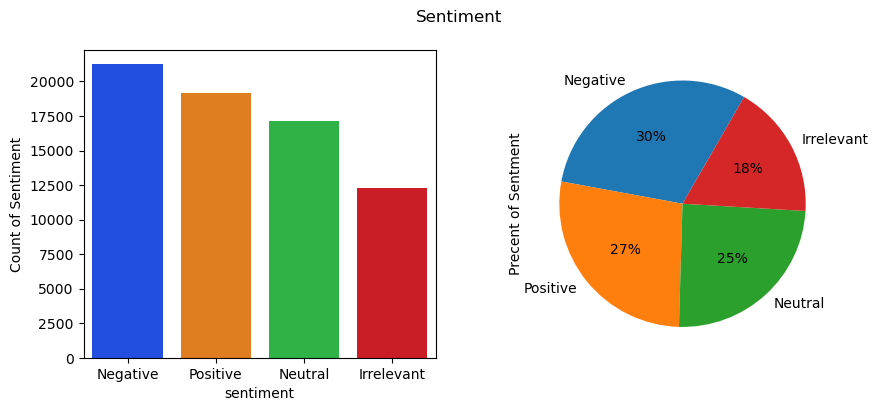

In [14]:
fig , ax = plt.subplots(1,2,figsize=(10,4))
sns.barplot(x=df['sentiment'].value_counts().index, y=df['sentiment'].value_counts(),palette='bright', ax=ax[0])
ax[0].set_ylabel('Count of Sentiment')
df['sentiment'].value_counts().plot.pie(autopct='%1.0f%%',startangle=60, ax=ax[1])
ax[1].set_ylabel('Precent of Sentment')
fig.suptitle('Sentiment')
plt.show()

* **Find the most common words that may affect the model**

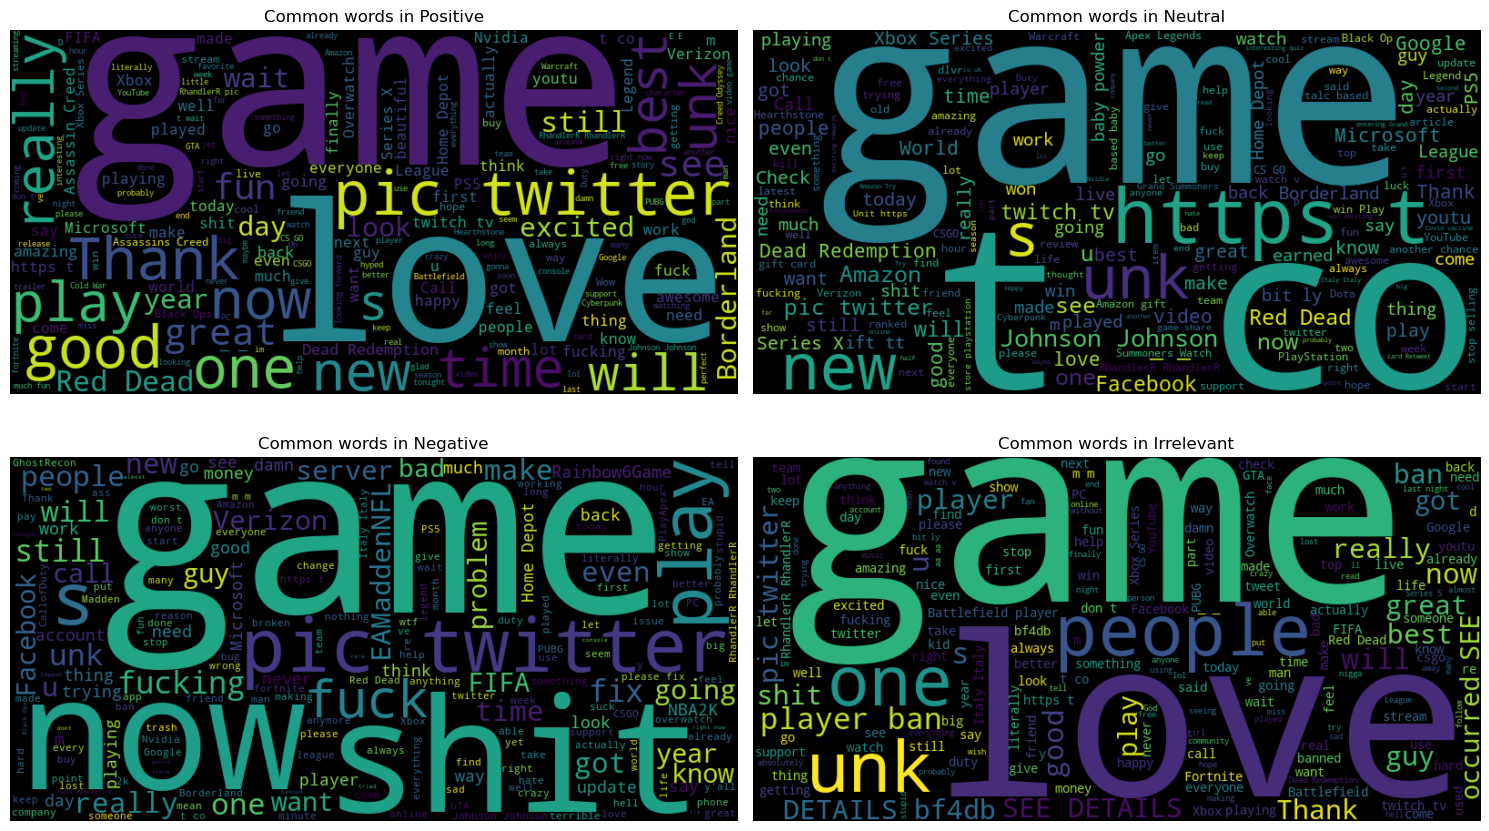

In [15]:
fig , ax = plt.subplots(2,2,figsize=(15,9))

for i, label in enumerate(df['sentiment'].unique()):
    text = ' '.join(df[df['sentiment']==label]['body'])
    # print(text, end ='\n\n')
    wordcloud = WordCloud(width=800, height=400).generate(text)
    row = i // 2
    col = i % 2
    ax[row][col].imshow(wordcloud, interpolation='bilinear')
    ax[row][col].axis('off')
    ax[row][col].set_title(f"Common words in {label}")
plt.tight_layout()
plt.show()

* **Analyze common words sequence**

In [16]:
for label in df['sentiment'].unique():
  vectorizer = CountVectorizer(ngram_range=(1, 2), stop_words='english')
  ngrams = vectorizer.fit_transform(df[df['sentiment'] == label]['body'])
  sum_ngrams = ngrams.sum(axis=0)
  words_freq = [(word, sum_ngrams[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
  words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
  # Top 8 n-grams
  print(label,':')
  print(words_freq[:8], '\n')

Positive :
[('game', 2262), ('com', 1846), ('love', 1709), ('just', 1666), ('good', 1551), ('like', 1323), ('really', 1266), ('pic', 1257)] 

Neutral :
[('com', 4089), ('johnson', 1880), ('just', 1595), ('amazon', 1373), ('https', 1353), ('game', 1310), ('facebook', 992), ('like', 907)] 

Negative :
[('game', 3777), ('just', 2184), ('com', 1814), ('like', 1621), ('shit', 1466), ('twitter', 1323), ('fix', 1309), ('pic', 1282)] 

Irrelevant :
[('com', 1821), ('player', 1127), ('just', 1116), ('ban', 990), ('like', 987), ('game', 802), ('people', 729), ('love', 669)] 



* **Make a copy from the DataFrame**

In [17]:
df_copy = df.copy()

* **Calculate punctuation percentage**

In [18]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

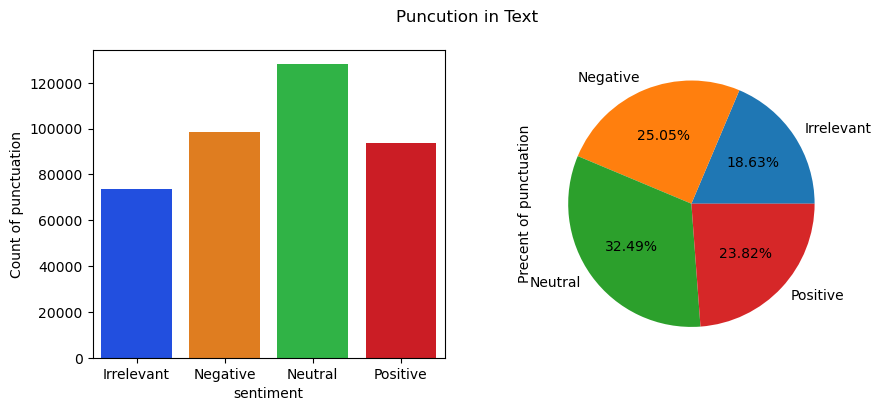

In [19]:
def count_punct(txt):
    count = sum([1 for i in txt if i in string.punctuation])
    return count

df_copy['count_punct'] = df_copy['body'].apply(lambda x : count_punct(x))
punct = df_copy.groupby('sentiment')['count_punct'].sum().reset_index()
punct['punct_precent'] = round((punct['count_punct'] / (punct['count_punct'].sum()) )*100, 2)
# print(punct)

fig , ax = plt.subplots(1,2,figsize=(10,4))
sns.barplot(x=punct['sentiment'], y=punct['count_punct'],palette='bright', ax=ax[0])
ax[0].set_ylabel('Count of punctuation')
punct['punct_precent'].plot.pie(labels=punct['sentiment'], autopct='%1.02f%%',startangle=0, ax=ax[1])
ax[1].set_ylabel('Precent of punctuation')

fig.suptitle('Puncution in Text')

plt.show()

* **Calculate count of links**

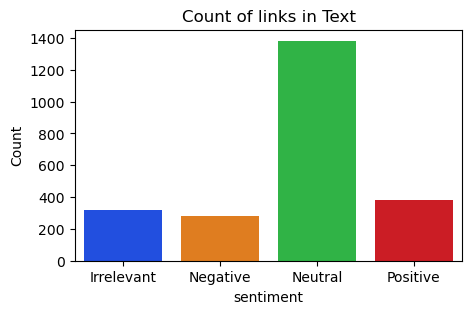

In [20]:
def count_link(txt):
    count = len(re.findall(r"\b(https?)",txt))
    return count

df_copy['count_link'] = df_copy['body'].apply(lambda x : count_link(x))
links = df_copy.groupby('sentiment')['count_link'].sum().reset_index()

plt.figure(figsize = (5,3))
sns.barplot(x=links['sentiment'], y=links['count_link'],palette='bright')
plt.title('Count of links in Text')
plt.ylabel('Count')
plt.show()

* **Calculate count of digits**

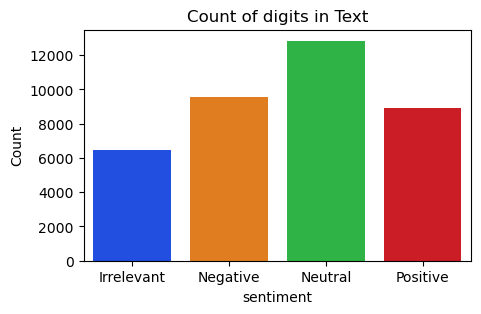

In [21]:
def count_digit(txt):
    count = len(re.findall(r"\b(one|two|three|four|five|six|seven|eight|nine|ten|\d+)\b",txt))
    return count

df_copy['count_digit'] = df_copy['body'].apply(lambda x : count_digit(x))
digit = df_copy.groupby('sentiment')['count_digit'].sum().reset_index()

plt.figure(figsize = (5,3))
sns.barplot(x=digit['sentiment'], y=digit['count_digit'],palette='bright')
plt.title('Count of digits in Text')
plt.ylabel('Count')
plt.show()

* **calculate count of length in each sentiment**

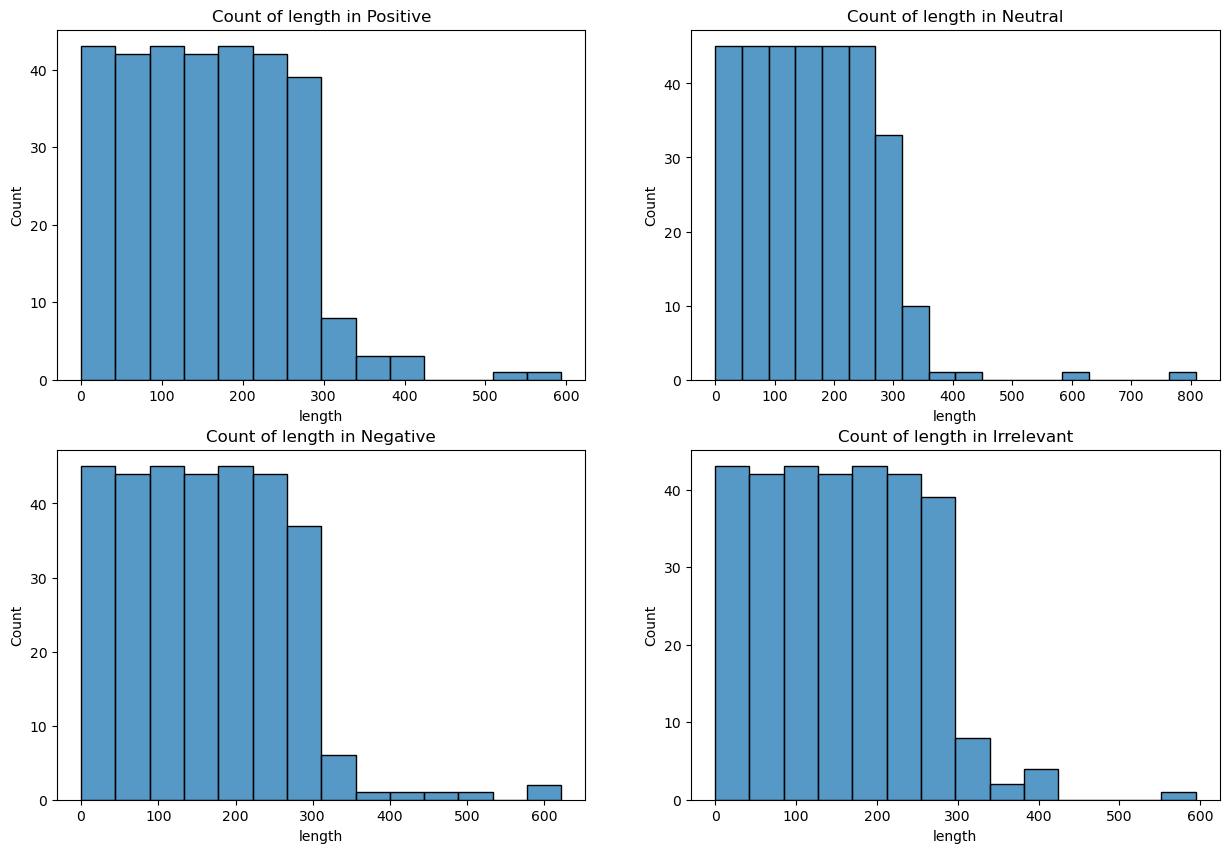

In [22]:
fig , ax = plt.subplots(2,2,figsize=(15,10))
df_copy['length'] = df_copy['body'].apply(lambda x : len(x)- x.count(' '))

for i, label in enumerate(df['sentiment'].unique()):
    length = df_copy[df_copy['sentiment'] == label].groupby('sentiment')['length'].value_counts().reset_index()
    row = i // 2
    col = i % 2
    sns.histplot(length['length'] ,ax =ax[row][col])
    ax[row][col].set_title(f"Count of length in {label}")
plt.show()

---

# Insights

* **The data is balanced**
* **There are common words we need to remove from each category(ex: game, like, com...)**
* **Remove punctuation**
* **Don't remove Links**
* **Remove digits and numbers**
* **Don't add lengh as a feature**

---


# **Data Preprocessing**

* ***Step 1:* convert all string to lowercase**

In [23]:
df['body'] = df['body'].apply(lambda x: x.lower())
df.head(3)

,sentiment,body
0,Positive,im getting on borderlands and i will murder yo...
1,Positive,i am coming to the borders and i will kill you...
2,Positive,im getting on borderlands and i will kill you ...


* ***Step 2:* Remove stop words and some common words**

In [24]:
#Define stop words and common words
common_words = set(['game', 'com', 'unk', 'like'])
stop_words = set(stopwords.words('english')).union(common_words)
#function to remove stop words
def remove_stop_words(txt):
    return ' '.join([x for x in txt.split() if x not in stop_words])

df['body'] = df['body'].apply(lambda x: remove_stop_words(x))
df.head(3)

,sentiment,body
0,Positive,"im getting borderlands murder ,"
1,Positive,"coming borders kill all,"
2,Positive,"im getting borderlands kill all,"


* ***Step 3:* Remove punctuation**

In [25]:
#Function to remove punctuation
def remove_punc(txt):
    text_non_punct = "".join([char for char in txt if char not in string.punctuation])
    return text_non_punct

df['body'] = df['body'].apply(lambda x: remove_punc(x))
df.head(3)

,sentiment,body
0,Positive,im getting borderlands murder
1,Positive,coming borders kill all
2,Positive,im getting borderlands kill all


* ***Step 4:* Remove digit and numbers**

In [26]:
def remove_digit(txt):
    text_non_digit = re.sub(r"\b(one|two|three|four|five|six|seven|eight|nine|ten|\d+)\b", '',txt).strip()
    return text_non_digit

df['body'] = df['body'].apply(lambda x: remove_digit(x))
df.head(3)

,sentiment,body
0,Positive,im getting borderlands murder
1,Positive,coming borders kill all
2,Positive,im getting borderlands kill all


* ***Step 5:* Tokenization**

In [27]:
df['body'] = df['body'].apply(lambda x: word_tokenize(x))
df.head(3)

,sentiment,body
0,Positive,"[im, getting, borderlands, murder]"
1,Positive,"[coming, borders, kill, all]"
2,Positive,"[im, getting, borderlands, kill, all]"


* ***Step 6:* Apply Lemmatizing**

In [28]:
lem = WordNetLemmatizer()
#function to lemmatize
def lemmatizing (txt):
    lemmtize = [lem.lemmatize(word,pos='v') for word in txt]
    return lemmtize

df['body'] = df['body'].apply(lambda x: lemmatizing(x))
df.head()

,sentiment,body
0,Positive,"[im, get, borderlands, murder]"
1,Positive,"[come, border, kill, all]"
2,Positive,"[im, get, borderlands, kill, all]"
3,Positive,"[im, come, borderlands, murder, all]"
4,Positive,"[im, get, borderlands, murder, all]"


* ***Step 7:* Return from tokenization to text**

In [29]:
df['body'] = df['body'].apply(lambda x: ' '.join(x))
df.head(3)

,sentiment,body
0,Positive,im get borderlands murder
1,Positive,come border kill all
2,Positive,im get borderlands kill all


* ***Step 8:* Split DataFrame to train model**

In [30]:
target = df['sentiment']
df.drop(columns=['sentiment'], inplace=True)

In [31]:
x_train, x_test, y_train, y_test = train_test_split(df, target, test_size=0.2, shuffle=True)

* ***Step 9:* Apply TF-IDF**

In [32]:
TFIDF = TfidfVectorizer(ngram_range=(1, 2))
tfidf_train = TFIDF.fit_transform(x_train['body'])
tfidf_test = TFIDF.transform(x_test['body'])

In [33]:
print(tfidf_train)

  (0, 85228)	0.3469579026037699
  (0, 101759)	0.37560372924477636
  (0, 176063)	0.2884878874448419
  (0, 21783)	0.36989261775958393
  (0, 175741)	0.37560372924477636
  (0, 138000)	0.3009538101197805
  (0, 90735)	0.14195196752435124
  (0, 85204)	0.2732703464011909
  (0, 101663)	0.18212864905459994
  (0, 21741)	0.2665155352114449
  (0, 175660)	0.25578459701582557
  (0, 137549)	0.14963524512053342
  (1, 126429)	0.1925062221615226
  (1, 252453)	0.1925062221615226
  (1, 84217)	0.1925062221615226
  (1, 41758)	0.1925062221615226
  (1, 101035)	0.1925062221615226
  (1, 251748)	0.1925062221615226
  (1, 146739)	0.17368483411353663
  (1, 103848)	0.17368483411353663
  (1, 9680)	0.1925062221615226
  (1, 243637)	0.1925062221615226
  (1, 60247)	0.16330053631671754
  (1, 49635)	0.17368483411353663
  (1, 110377)	0.17680836077105486
  :	:
  (55813, 35597)	0.12158058851380368
  (55813, 268479)	0.14023393654240215
  (55813, 229447)	0.13197403329381552
  (55813, 251598)	0.12444502750163658
  (55814, 256236)

In [34]:
words = TFIDF.get_feature_names_out()

In [35]:
print(len(words))

270915


**Visualizing Feature Density**

Sparsity: 0.01%


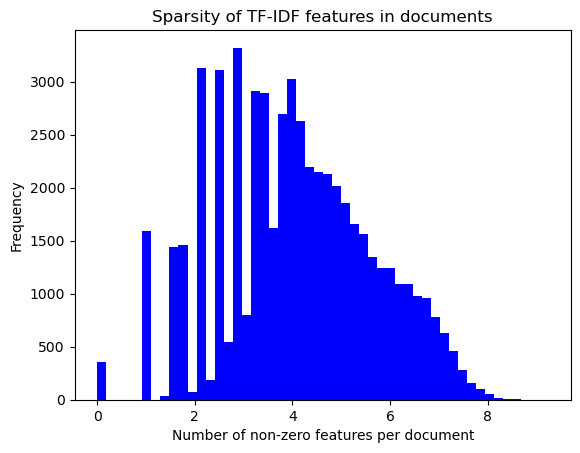

In [36]:
# Calculate sparsity
sparsity = (tfidf_train.nnz / (tfidf_train.shape[0] * tfidf_train.shape[1])) * 100
print(f"Sparsity: {sparsity:.2f}%")

# Visualizing Sparsity
plt.hist(np.asarray(tfidf_train.sum(axis=1)).flatten(), bins=50, color='blue')
plt.xlabel('Number of non-zero features per document')
plt.ylabel('Frequency')
plt.title('Sparsity of TF-IDF features in documents')
plt.show()


**Term Frequency Distribution**

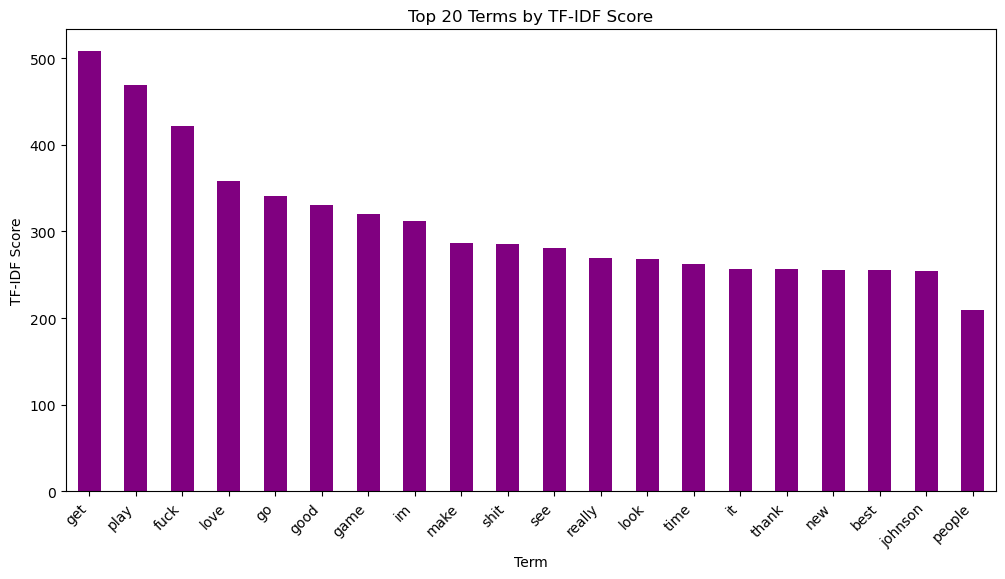

In [37]:
# Get feature names
feature_names = TFIDF.get_feature_names_out()

# Get the sum of TF-IDF values for each feature
total_tf_idf = tfidf_train.sum(axis=0).A1  # convert sparse matrix to array
sorted_items = sorted(zip(total_tf_idf, feature_names), reverse=True)

# Visualize the top 20 features
top_n = 20
sorted_df = pd.DataFrame(sorted_items[:top_n], columns=['TF-IDF Score', 'Term'])
sorted_df.plot(kind='bar', x='Term', y='TF-IDF Score', figsize=(12, 6), legend=False, color='purple')
plt.title('Top 20 Terms by TF-IDF Score')
plt.xlabel('Term')
plt.ylabel('TF-IDF Score')
plt.xticks(rotation=45, ha='right')
plt.show()


**Save TF-IDF**

In [38]:
joblib.dump(TFIDF, 'TFIDF_model.pkl')

['TFIDF_model.pkl']

#  **Model selection**

*   **Naive Bayes**
*   **KNN**
*   **Decision Trees**
*   **SVM**
*   **Logistic Regression**
*   **Random Forest**



## **Naive Bayes**


* **Model Training**

In [39]:
nb_model = MultinomialNB(alpha=0.01)
nb_model.fit(tfidf_train, y_train)

MultinomialNB(alpha=0.01)

* **Make Prediction**

In [40]:
yhat_train = nb_model.predict(tfidf_train)
yhat_test = nb_model.predict(tfidf_test)

* **Evaluation of the model on train data**

In [41]:
accuracy_NB_train = accuracy_score(y_train, yhat_train)
print(f'Train Accuracy: {accuracy_NB_train:.2f}')

Train Accuracy: 0.98


* **Evaluation of the model on test data**

In [42]:
accuracy_NB_test = accuracy_score(y_test, yhat_test)
print(f'Test Accuracy: {accuracy_NB_test:.2f}')

print("Classification Report (Test Set):")
print(classification_report(y_test, yhat_test))

Test Accuracy: 0.94
Classification Report (Test Set):
              precision    recall  f1-score   support

  Irrelevant       0.97      0.91      0.94      2407
    Negative       0.93      0.96      0.94      4336
     Neutral       0.96      0.93      0.94      3458
    Positive       0.92      0.95      0.93      3753

    accuracy                           0.94     13954
   macro avg       0.94      0.94      0.94     13954
weighted avg       0.94      0.94      0.94     13954



* **Confusion Matrix**

[[2200   81   31   95]
 [  24 4159   48  105]
 [  19  122 3202  115]
 [  29  116   41 3567]]


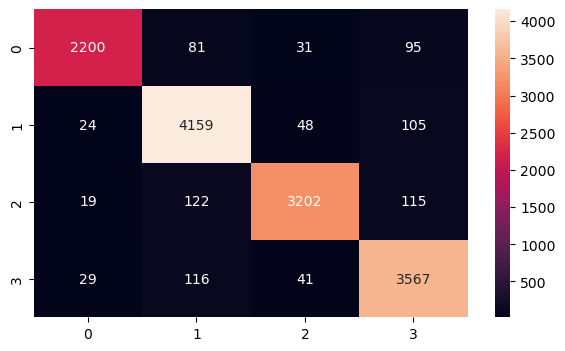

In [43]:
plt.figure(figsize = (7,4))
Cm_NB = confusion_matrix(y_test, yhat_test)
sns.heatmap(Cm_NB ,annot =True, fmt='d')
print(Cm_NB)
plt.show()

## **KNN**

* **Model Training**

In [44]:
knn = KNeighborsClassifier(n_neighbors= 5)
knn.fit(tfidf_train, y_train)

KNeighborsClassifier()

* **Make Prediction**

In [45]:
yhat_train = knn.predict(tfidf_train)
yhat_test = knn.predict(tfidf_test)

* **Evaluation of the model on train data**

In [46]:
accuracy_knn_train = accuracy_score(y_train, yhat_train)
print(f'Train Accuracy: {accuracy_knn_train:.2f}')

Train Accuracy: 0.89


* **Evaluation of the model on test data**

In [47]:
accuracy_knn_test = accuracy_score(y_test, yhat_test)
print(f'Test Accuracy: {accuracy_knn_test:.2f}')

print("Classification Report (Test Set):")
print(classification_report(y_test, yhat_test))

Test Accuracy: 0.83
Classification Report (Test Set):
              precision    recall  f1-score   support

  Irrelevant       0.97      0.70      0.82      2407
    Negative       0.66      0.98      0.79      4336
     Neutral       0.98      0.66      0.79      3458
    Positive       0.96      0.88      0.92      3753

    accuracy                           0.83     13954
   macro avg       0.89      0.81      0.83     13954
weighted avg       0.87      0.83      0.83     13954



* **Confusion Matrix**

[[1692  656    7   52]
 [  20 4260    6   50]
 [  10 1106 2290   52]
 [  19  387   26 3321]]


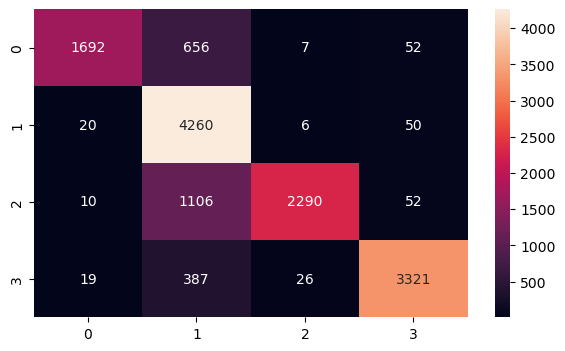

In [48]:
plt.figure(figsize = (7,4))
Cm_NB = confusion_matrix(y_test, yhat_test)
sns.heatmap(Cm_NB ,annot =True, fmt='d')
print(Cm_NB)
plt.show()

## **Descision Tree**

* **Model Training**

In [49]:
decision_tree = DecisionTreeClassifier(random_state= 0)
decision_tree.fit(tfidf_train, y_train) 

DecisionTreeClassifier(random_state=0)

* **Make Prediction**

In [50]:
yhat_train = decision_tree.predict(tfidf_train)
yhat_test = decision_tree.predict(tfidf_test)

* **Evaluation of the model on train data**

In [51]:
accuracy_dt_train = accuracy_score(y_train, yhat_train)
print(f'Train Accuracy: {accuracy_dt_train:.2f}')

Train Accuracy: 0.99


* **Evaluation of the model on test data**

In [52]:
accuracy_dt_test = accuracy_score(y_test, yhat_test)
print(f'Test Accuracy: {accuracy_dt_test:.2f}')

print("Classification Report (Test Set):")
print(classification_report(y_test, yhat_test))

Test Accuracy: 0.77
Classification Report (Test Set):
              precision    recall  f1-score   support

  Irrelevant       0.75      0.68      0.71      2407
    Negative       0.80      0.82      0.81      4336
     Neutral       0.76      0.73      0.74      3458
    Positive       0.75      0.80      0.77      3753

    accuracy                           0.77     13954
   macro avg       0.76      0.76      0.76     13954
weighted avg       0.77      0.77      0.77     13954



* **Confusion Matrix**

[[1639  224  209  335]
 [ 205 3554  285  292]
 [ 169  379 2510  400]
 [ 186  259  292 3016]]


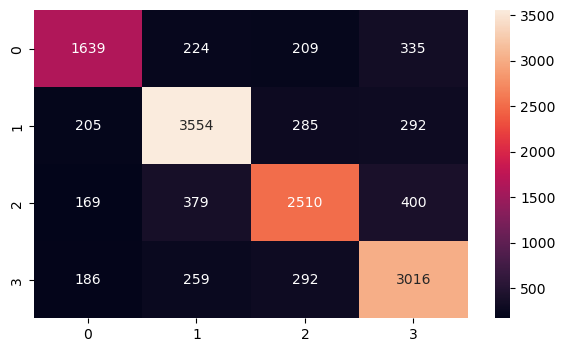

In [53]:
plt.figure(figsize = (7,4))
Cm_NB = confusion_matrix(y_test, yhat_test)
sns.heatmap(Cm_NB ,annot =True, fmt='d')
print(Cm_NB)
plt.show()

## **SVM**

* **Grid Search for SVM**

In [32]:
param_grid = {
    'kernel': ['linear', 'sigmoid'],
    'C': [0.1, 1],
    'gamma': [0.1, 1], 
    'random_state': [0],
}

model = SVC()

grid_search = GridSearchCV(model, param_grid, cv=5) 
grid_search.fit(tfidf_train, y_train)

print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: ", grid_search.best_score_)

Best parameters found:  {'C': 1, 'gamma': 0.1, 'kernel': 'linear', 'random_state': 0}
Best cross-validation score:  0.9087521275642748


* **Model Training**

In [54]:
svm = SVC(kernel= 'linear', gamma=0.1, C=1, random_state= 0)
svm.fit(tfidf_train, y_train)

SVC(C=1, gamma=0.1, kernel='linear', random_state=0)

* **Make Prediction**

In [55]:
yhat_train = svm.predict(tfidf_train)
yhat_test = svm.predict(tfidf_test)

* **Evaluation of the model on validation data**

In [56]:
accuracy_svm_train = accuracy_score(y_train, yhat_train)
print(f'Train Accuracy: {accuracy_svm_train:.2f}')

Train Accuracy: 0.98


* **Evaluation of the model on test data**

In [57]:
accuracy_svm_test = accuracy_score(y_test, yhat_test)
print(f'Test Accuracy: {accuracy_svm_test:.2f}')
print("Classification Report (Test Set):")
print(classification_report(y_test, yhat_test))

Test Accuracy: 0.93
Classification Report (Test Set):
              precision    recall  f1-score   support

  Irrelevant       0.95      0.90      0.93      2407
    Negative       0.94      0.95      0.94      4336
     Neutral       0.92      0.93      0.93      3458
    Positive       0.92      0.94      0.93      3753

    accuracy                           0.93     13954
   macro avg       0.93      0.93      0.93     13954
weighted avg       0.93      0.93      0.93     13954



* **Confusion Matrix**

[[2178   58   65  106]
 [  39 4115   90   92]
 [  33  115 3206  104]
 [  36   86  110 3521]]


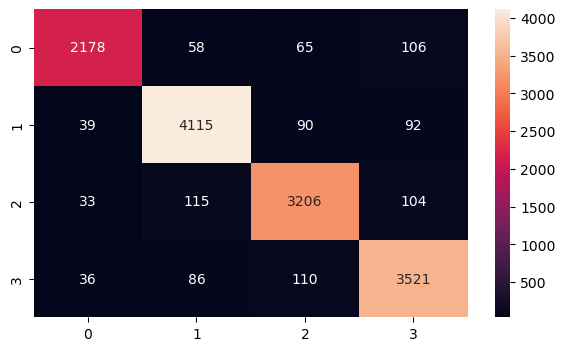

In [58]:
plt.figure(figsize = (7,4))
Cm_NB = confusion_matrix(y_test, yhat_test)
sns.heatmap(Cm_NB ,annot =True, fmt='d')
print(Cm_NB)
plt.show()

## **Logistic Regression**

* **Model Training**

In [59]:
logistic_reg = LogisticRegression(max_iter=1000, C= 100)
logistic_reg.fit(tfidf_train, y_train)

LogisticRegression(C=100, max_iter=1000)

* **Make Prediction**

In [60]:
yhat_train = logistic_reg.predict(tfidf_train)
yhat_test = logistic_reg.predict(tfidf_test)

* **Evaluation of the model on train data**

In [61]:
accuracy_lr_train = accuracy_score(y_train, yhat_train)
print(f'Train Accuracy: {accuracy_lr_train:.2f}')

Train Accuracy: 0.99


* **Evaluation of the model on test data**

In [62]:
accuracy_lr_test = accuracy_score(y_test, yhat_test)
print(f'Test Accuracy: {accuracy_lr_test:.2f}')
print("Classification Report (Test Set):")
print(classification_report(y_test, yhat_test))

Test Accuracy: 0.94
Classification Report (Test Set):
              precision    recall  f1-score   support

  Irrelevant       0.95      0.91      0.93      2407
    Negative       0.95      0.95      0.95      4336
     Neutral       0.93      0.94      0.93      3458
    Positive       0.93      0.94      0.93      3753

    accuracy                           0.94     13954
   macro avg       0.94      0.93      0.94     13954
weighted avg       0.94      0.94      0.94     13954



* **Confusion Matrix**

[[2186   61   63   97]
 [  39 4128   87   82]
 [  31   89 3243   95]
 [  35   79  109 3530]]


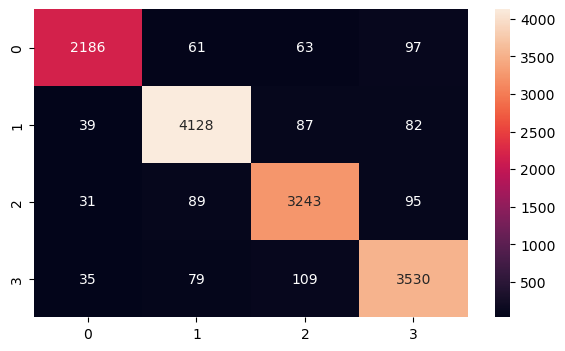

In [63]:
plt.figure(figsize = (7,4))
Cm_NB = confusion_matrix(y_test, yhat_test)
sns.heatmap(Cm_NB ,annot =True, fmt='d')
print(Cm_NB)
plt.show()

## **Random Forest**

* **Model Training**

In [64]:
random_forest = RandomForestClassifier(n_estimators= 110, random_state = 0)
random_forest.fit(tfidf_train, y_train)

RandomForestClassifier(n_estimators=110, random_state=0)

* **Make Prediction**

In [65]:
yhat_train = random_forest.predict(tfidf_train)
yhat_test = random_forest.predict(tfidf_test)

* **Evaluation of the model on train data**

In [66]:
accuracy_rf_train = accuracy_score(y_train, yhat_train)
print(f'Train Accuracy: {accuracy_rf_train:.2f}')

Train Accuracy: 0.99


* **Evaluation of the model on test data**

In [67]:
accuracy_rf_test = accuracy_score(y_test, yhat_test)
print(f'Test Accuracy: {accuracy_rf_test:.2f}')

print("Classification Report (Test Set):")
print(classification_report(y_test, yhat_test))

Test Accuracy: 0.90
Classification Report (Test Set):
              precision    recall  f1-score   support

  Irrelevant       0.97      0.83      0.89      2407
    Negative       0.89      0.95      0.92      4336
     Neutral       0.94      0.86      0.90      3458
    Positive       0.86      0.94      0.90      3753

    accuracy                           0.90     13954
   macro avg       0.92      0.90      0.90     13954
weighted avg       0.91      0.90      0.90     13954



* **Confusion Matrix**

[[1995  148   55  209]
 [  21 4127   58  130]
 [  26  230 2986  216]
 [  13  146   74 3520]]


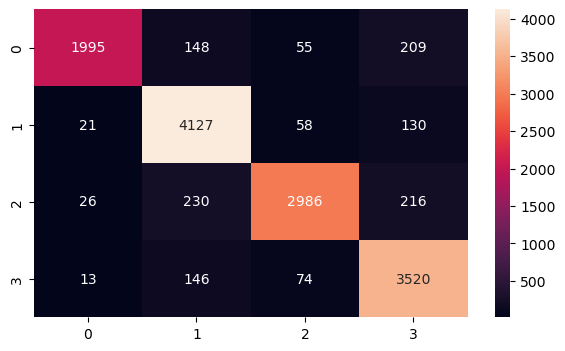

In [68]:
plt.figure(figsize = (7,4))
Cm_NB = confusion_matrix(y_test, yhat_test)
sns.heatmap(Cm_NB ,annot =True, fmt='d')
print(Cm_NB)
plt.show()

## **Save the models**

In [69]:
joblib.dump(random_forest, 'random_forest_model.pkl')
joblib.dump(logistic_reg, 'logistic_reg_model.pkl')
joblib.dump(svm, 'svm_model.pkl')
joblib.dump(decision_tree, 'decision_tree_model.pkl')
joblib.dump(knn, 'knn_model.pkl')

['knn_model.pkl']

## **Plotting Train vs Test Set Accuracies**

In [70]:
accuracies = {
    'Naive Bayes': [accuracy_NB_train, accuracy_NB_test],
    'KNN': [accuracy_knn_train, accuracy_knn_test],             
    'Decision Tree': [accuracy_dt_train, accuracy_dt_test],    
    'SVM': [accuracy_svm_train, accuracy_svm_test],              
    'Logistic Regression': [accuracy_lr_train, accuracy_lr_test], 
    'Random Forest': [accuracy_rf_train, accuracy_rf_test] 
}
accuracies_df = pd.DataFrame(accuracies)

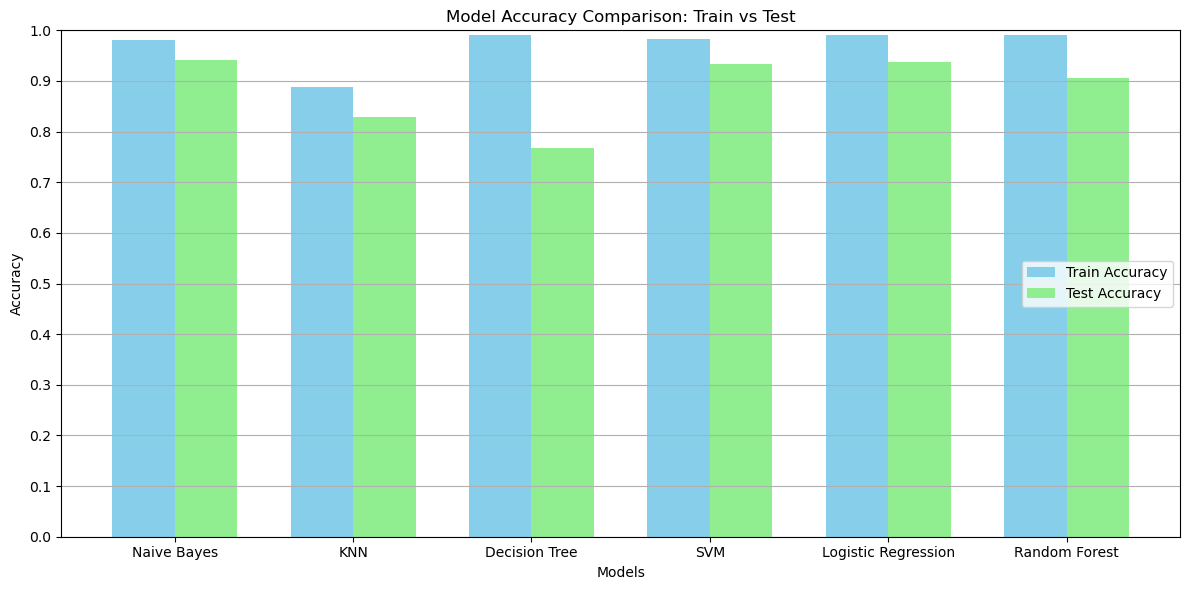

In [71]:
models = list(accuracies.keys())
train_accuracies = list(accuracies_df.iloc[0])
test_accuracies = list(accuracies_df.iloc[1])

bar_width = 0.35

x = np.arange(len(models))

plt.figure(figsize=(12, 6))
bars1 = plt.bar(x - bar_width/2, train_accuracies, bar_width, label='Train Accuracy', color='skyblue')
bars2 = plt.bar(x + bar_width/2, test_accuracies, bar_width, label='Test Accuracy', color='lightgreen')

plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison: Train vs Test')
plt.xticks(x, models)
plt.ylim(0, 1)  
plt.yticks(np.arange(0, 1.1, 0.1))
plt.legend(loc = 'right')
plt.grid(axis='y')

plt.tight_layout()
plt.show()